# Building Zero Curves

In this session we will look at how to build zero curves using OpenRedukti.

### Overview of steps

The process involves following steps:

* Create a file containing curve definitions
* Create a file containing par rates
* Start the OpenRedukti server
* Send a bootstrap request to the server
* Construct the curve objects from the raw data returned by the server

Note that we do not necessarily have to create the files above. We could supply data by populating relevant data structures. It is just more tedious work.

Currently the bootstrap function is not exposed in the Python api hence we need to send a request to the server. In future once this function is exposed in the Python api, it will not be necessary to send the request to the server. 
Note that if par sensitivities are requested then it can take quite some time to generate the curve data, hence in that case uisng a server is advisable.

### Curve Definitions
Okay so we start by creating a curve definitions file. This is just a CSV file. The example we will use can be found at [github.com/redukti/PyRedukti/blob/master/testdata/20121211/curve_definitions.csv](https://github.com/redukti/PyRedukti/blob/master/testdata/20121211/curve_definitions.csv).

Note that each curve is given a numeric id that must be unique. I will explain the curve definition parameters in a subsequent session.

### PAR Rates or market quotes
Next we need to create a par rates file. This is also a CSV file. The example we will use can be found at 
[https://github.com/redukti/PyRedukti/blob/master/testdata/20121211/par_rates.csv](https://github.com/redukti/PyRedukti/blob/master/testdata/20121211/par_rates.csv). 

Please note the use of the curve ids as the forward and discounting curve ids in the par rates data. This highlights an important aspect of OpenRedukti's curve builder: **it bootstraps multiple curves simultaneously**. Hence you need to supply all the inter-related curves together. Usually it means submitting all curves for a single currency in one request.

There are a number of details to note when creating the par rates data: I will cover these later in this session.

### Start OpenRedukti Server

The easiest way to do this is to use Docker. Docker images will be available soon for you to download and run the server with minimal effort.

Once you have the docker image, the command to start the server is:

```
docker run --rm -d -p 9001:9001/tcp redukti-grpc-server:latest
```

Above starts the service and enables port 9001.

### Checking that server is up

In [13]:
from redukti.library import ServerCommand

In [14]:
server_command = ServerCommand('localhost:9001')

In [15]:
server_command.hello('hello redukti')

'hello redukti'

The server has echoed back our input so that means it is running.

### Loading Market Data 

We can now load the curve definitions and par rates into memory structures using a library function provided by redukti.

In [16]:
from redukti.library import MarketData

In [17]:
import redukti

In [18]:
market_data = MarketData(redukti.dmy(11,12,2012)) # business date is 11th Dec 2012

In [19]:
market_data.read_curvedefinitions('../testdata/20121211/curve_definitions.csv')

In [20]:
market_data.read_parcurves('../testdata/20121211/par_rates.csv')

### Building Curves

So now the data has been loaded and we have created the memory structures needed to submit the bootstrap request. Note that as I mentioned before, we could have done this manually rather than loading from data files.

We can now request the server to bootstrap the curves. The library provides a wrapper that invokes the server request and converts the result to yield curves we can actually use.

In [21]:
server_command.build_curves(market_data)

Curve 7 created
Curve 8 created
Curve 9 created
Curve 10 created


The built curves are available in the market_data object:

In [22]:
market_data._yield_curves

In [23]:
import matplotlib.pyplot as plt

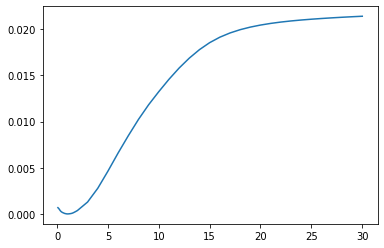

In [26]:
import redukti
from redukti import enums_pb2 as enums
start_date = redukti.dmy(11,12,2012)
dates = []
for x in range(1,23):
    dates.append(redukti.advance(start_date,x,enums.MONTHS))
for x in range(2,31):
    dates.append(redukti.advance(start_date,x,enums.YEARS))
mycurve = market_data._yield_curves[0]
x_axis = []
for d in dates:
    x_axis.append(mycurve.time_from_reference(d))
y_axis = []
for d in dates:
    y_axis.append(mycurve.zero_rate(d))
plt.plot(x_axis, y_axis)